# Classification Labelling: Demonstration and Plots

In [10]:
import pandas as pd
import numpy as np
import datetime
from ppym import pimdb as p
from ppym import pimhc as hc
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import Labels
import importlib
importlib.reload(Labels)
from sklearn.model_selection import train_test_split

C:\Users\Zubeida.Patel\AppData\Local\Temp\ipykernel_20580\2324406188.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### Get Data
Fetches the S&P 500 index over an example two year period.

In [3]:
db_engine = p.create_engine_pim(
    driver='mysql+pymysql',
    host='pim-cpt-mysql-prod.prescient.local',
    port=3307,
    database='prime_eav',
    username='zubeida.patel',
    password='zubeida.patel',
    connect_args=None
)

df = p.get_series(
    ['SPX Index'],
    ['PX_last'], 
    start_date=datetime.date(2003, 1, 1),
    end_date=datetime.date(2005, 1, 1),
    list_source_codes=['BB'],
    db_engine=db_engine
)

# Create a series of prices. This is the simplest form of an indexed set of data. 
S = pd.Series(df.value.values, index =df.datestamp.values)

# Create the label object. This is a work in progress and will likely be changed to accomodate future methods and models.
label = Labels.ClassificationLabels(S)



### The Cumulative Summation Filter
Symmetric Cusum Filter - Samples events according to postive (or negative) changes that exceed a threshold, $s$ (or $-s$). <br />
Asymmetric Cusum Filter - Samples events according to positive changes that exceed a threshold $s$

          full_dataset  events_asym   events_sym  diff_full_asym  \
mean       1047.938552  1028.543281  1010.270176       19.395271   
median     1082.889954  1031.834961  1014.569977       51.054993   
std         102.293075   108.376098   111.952280       -6.083023   
skew         -0.671118    -0.234156    -0.202129       -0.436962   
kurtosis     -0.569882    -1.151874    -1.252879        0.581992   
p25         986.134995   929.812515   911.009995       56.322479   
p75        1126.647522  1125.632507  1110.372498        1.015015   

          diff_full_sym  
mean          37.668375  
median        68.319977  
std           -9.659204  
skew          -0.468989  
kurtosis       0.682997  
p25           75.125000  
p75           16.275024  


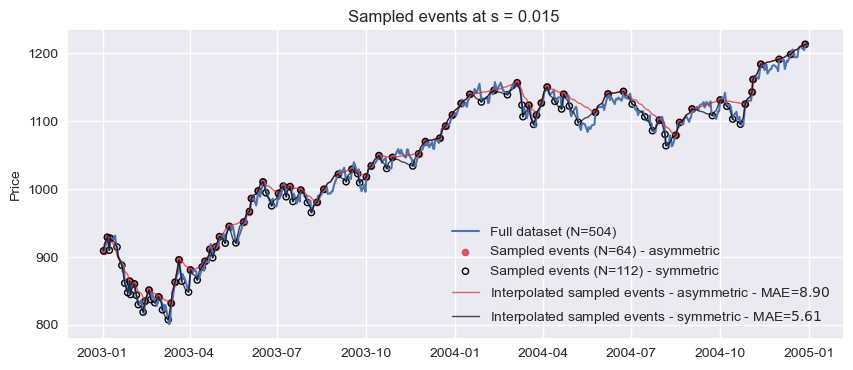

In [4]:
s = 0.015  # Threshold 
events_asym = label.cusum_filter_asym(s)
events_sym = label.cusum_filter_sym(s)

events_loc_asym = S.loc[events_asym] 
events_loc_sym = S.loc[events_sym] 

S_interp_asym = label.cusum_interp(events_asym)
S_interp_sym = label.cusum_interp(events_sym)


## Mean absolute error: 
diff_asym = (S - S_interp_asym).abs().sum()/S.shape[0]
diff_sym = (S - S_interp_sym).abs().sum()/S.shape[0]


## Plots

fig = plt.figure(figsize=(10,4))

plt.plot(S.index, S.values, linewidth=1.5, label = 'Full dataset (N={})'.format(S.shape[0]))

plt.scatter(events_loc_asym.index, events_loc_asym.values, marker = 'o', s=20, linewidth=1, color = 'tab:red', alpha=0.7, label='Sampled events (N={}) - asymmetric'.format(events_loc_asym.shape[0])) 
plt.scatter(events_loc_sym.index, events_loc_sym.values, marker = 'o', s=20, linewidth=1, facecolors='None', color = 'black', alpha=1, label='Sampled events (N={}) - symmetric'.format(events_loc_sym.shape[0]))

plt.plot(S_interp_asym.index, S_interp_asym.values, color = 'tab:red', linewidth = 1, alpha = 0.7, label='Interpolated sampled events - asymmetric - MAE=${:.2f}$'.format(diff_asym))
plt.plot(S_interp_sym.index, S_interp_sym.values, color = 'black', linewidth = 1, alpha = 0.7, label='Interpolated sampled events - symmetric - MAE=${:.2f}$'.format(diff_sym))
plt.title('Sampled events at s = {} '.format(s))

plt.ylabel('Price')
plt.legend()

## Descriptive statistics

S_statistics = [S.mean(), S.median(), S.std(), S.skew(), S.kurtosis(), S.quantile(0.25), S.quantile(0.75)]
df_statistics = pd.DataFrame(S_statistics,  columns = ['full_dataset'], index=['mean','median', 'std', 'skew', 'kurtosis', 'p25', 'p75'])

events_statistics_asym = events_loc_asym.mean(), events_loc_asym.median(), events_loc_asym.std(), events_loc_asym.skew(), events_loc_asym.kurtosis(), events_loc_asym.quantile(0.25), \
events_loc_asym.quantile(0.75)

events_statistics_sym = events_loc_sym.mean(), events_loc_sym.median(), events_loc_sym.std(), events_loc_sym.skew(), events_loc_sym.kurtosis(), events_loc_sym.quantile(0.25), \
events_loc_sym.quantile(0.75)

df_statistics['events_asym'] = events_statistics_asym
df_statistics['events_sym'] = events_statistics_sym
df_statistics['diff_full_asym'] = df_statistics.full_dataset - df_statistics.events_asym
df_statistics['diff_full_sym'] = df_statistics.full_dataset - df_statistics.events_sym

print(df_statistics)

The error signal remaining after removing the sampled dataset from the original dataset is shown below. 

Text(0, 0.5, 'Error')

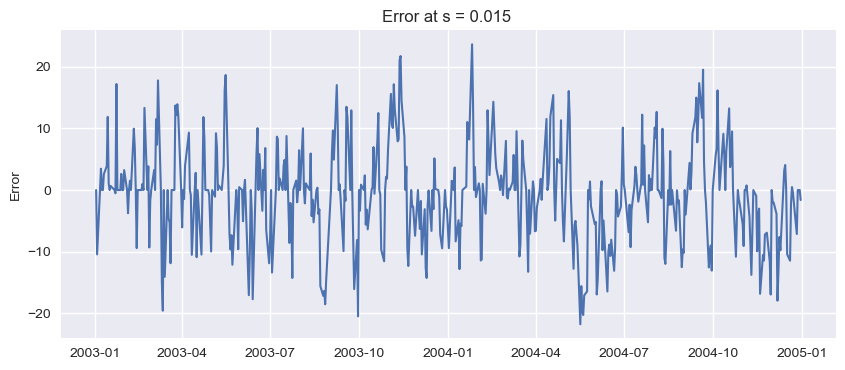

In [5]:
fig = plt.figure(figsize=(10,4))
plt.plot((S - S_interp_sym).index, (S - S_interp_sym).values, linewidth=1.5)
plt.title('Error at s = {} '.format(s))
plt.ylabel('Error')

### The Fixed-Time Horizon Method 
In this labelling method the horizon $h$ over which the returns are calculated is fixed - hence the name fixed-time horizon. It should be noted that there is an option of calculating these returns using either the forward or backward difference method, given as: <br />
Forward return: $r_{i+h} = \frac{P_{i+h}}{P_{i}} -1 $, &nbsp;   Backward return: $r_{i} = \frac{P_{i}}{P_{i-h}} -1 $. <br />
Plots showing the fixed-time labelling method can viewed below, using either a fixed threshold, $T$ or a dynamic threshold calculated at each time bar using an exponentially weighted moving average over a period $W$. 



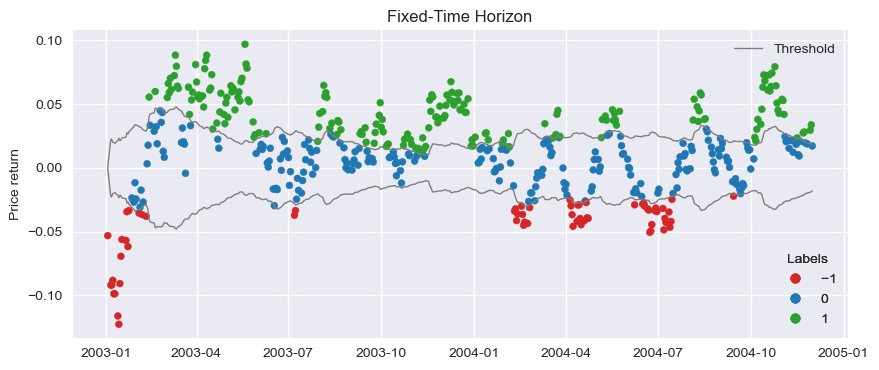

In [6]:
df = df[['datestamp','value']]
W = 30 # Window, in days, over which to compute the dynamic threshold.
h = 30 # Horizon, in days, over which to calcuate the returns.
T = None # Fixed threshold.
dynamic = True 
df_out, threshold = label.fixed_time_horizon(h, dynamic, T, W) # Uses forward returns.

colors = ['tab:red','tab:blue','tab:green']
fig, ax = plt.subplots(figsize=(10,4))
sct = ax.scatter(df_out.index, df_out['return'], c=df_out.label, cmap=matplotlib.colors.ListedColormap(colors), s=25)
plt.plot(threshold.index, threshold.values, label='Threshold',color='tab:gray', linewidth=1.0, )
plt.plot(threshold.index, -threshold.values, color='tab:gray', linewidth=1.0)
plt.ylabel('Price return')
plt.title('Fixed-Time Horizon')
legend2 = plt.legend()
legend1 = plt.legend(*sct.legend_elements(), title="Labels", loc='lower right')
ax.add_artist(legend1)
ax.add_artist(legend2)

### The Triple-Barrier Method 
This method uses three barriers, a vertical and two horizontal barriers, to label the return at time $t_{i}$. These barriers can be visualised as a box centered at zero at current time, $t_{i}$ and extending to the vertical barrier at time $t_{i}+d$. The upper and lower horizontal barriers, $\sigma_{u}c_{u}$ and $\sigma_{l}c_{l}$, are characterised by the price volatility, calculated using dynamic thresholding, that for simplicty can be thought of as symmetric. <br />
a) Vertical barrier - taken at a fixed length, $d$, in days from the current time bar. <br />
b) Horizontal barriers -  generated using dynamic thresholding and multiplied by factors $c_{u}$=$c_{l}$    <br /> 

An example of the barriers formed at time $t_{i}$ is shown below. This is followed by a plot of the classification labels.


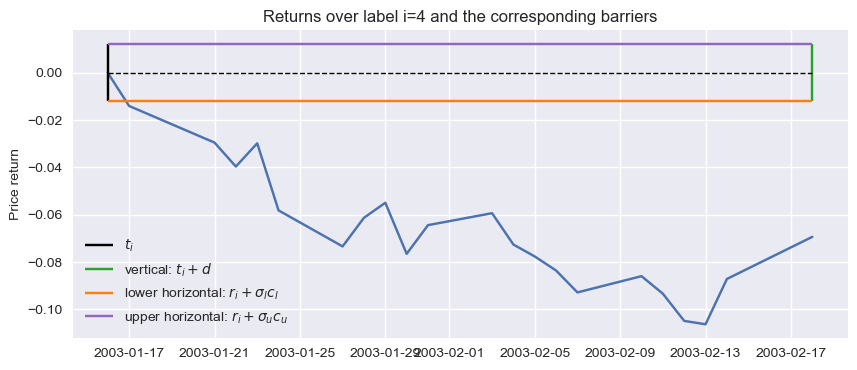

In [7]:
s = 0.015 # threshold for the sampled events
d = 30 # length of the vertical barrier in days
h = 30 # period in days over which to calcuate the price return 
W = 30 # window over which to compute the dynamic threshold
pt_sl= [0.5,0.5]  # horizontal barrier multiplication factors 

events = label.cusum_filter_sym(s)
T = label.dynamic_threshold(W, h, True)
vert_barrier = label.vertical_barrier(events, d) # vertical barrier
pt,sl = label.horizontal_barrier(T, events, pt_sl) # upper and lower barrier 
r = label.abs_return_forward(h) # estimated price return for visual purposes

fig = plt.figure(figsize=(10,4))

plt.ylabel('Price return')
i = 4

prices = S.loc[vert_barrier.index[i]:vert_barrier.values[i]]
returns = prices/prices.iloc[0] -1 

plt.plot(returns.index, returns.values) 

plt.vlines(x = vert_barrier.index[i], ymin=sl.values[i], ymax=pt.values[i], color = 'black', label = '$t_{i}$')   # current time 'barrier'
plt.vlines(x = vert_barrier.values[i],  ymin=sl.values[i], ymax=pt.values[i], color = 'tab:green', label = 'vertical: $t_{i}+d$') # vertical barrier d days later
plt.hlines(y = sl.values[i], xmin = vert_barrier.index[i] , xmax =  vert_barrier.values[i],  color = 'tab:orange', label = 'lower horizontal: $r_{i}+\sigma_{l}c_{l}$') # lower horizontal barrier
plt.hlines(y = pt.values[i], xmin = vert_barrier.index[i] , xmax =  vert_barrier.values[i],  color = 'tab:purple', label = 'upper horizontal: $r_{i}+\sigma_{u}c_{u}$') # upper horizontal barrier
plt.hlines(y = 0, xmin = vert_barrier.index[i] , xmax =  vert_barrier.values[i],  color = 'black', linestyle="--", linewidth=1) # center line

plt.title('Returns over label i={0} and the corresponding barriers'.format(i))
plt.legend(loc='lower left') 
plt.show()

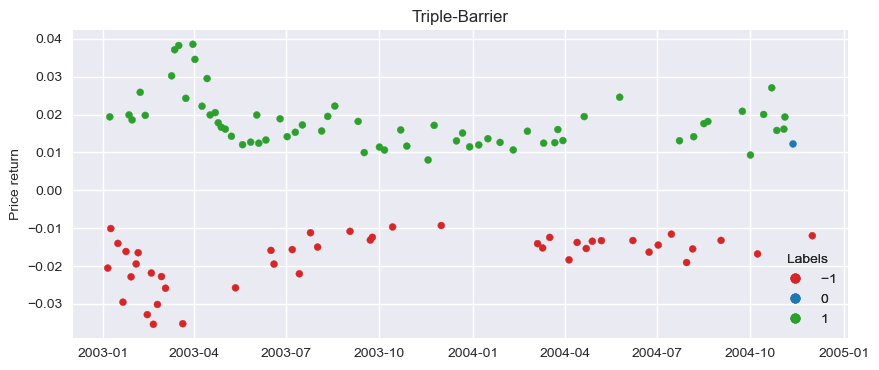

In [8]:
df_events = label.get_events(T,  vert_barrier, events, pt_sl,  0.001, side=False)
df_labels = label.triple_barrier(df_events)

colors = ['tab:red','tab:blue','tab:green']
fig, ax = plt.subplots(figsize=(10,4))
sct = ax.scatter(df_labels.index, df_labels['return'], c=df_labels.label, cmap=matplotlib.colors.ListedColormap(colors), s=25)
plt.ylabel('Price return')
plt.title('Triple-Barrier')
legend1 = plt.legend(*sct.legend_elements(),title="Labels")
ax.add_artist(legend1)

### Sample weights

Sum of the weights:  108.99999999999997


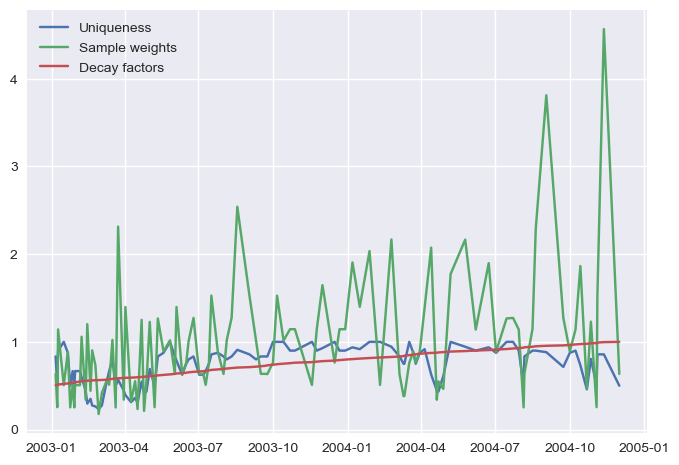

In [9]:
num_conc = label.num_conc_events(df_labels['date touched'])
u = label.uniqueness(num_conc, df_labels['date touched'])
weights = label.weights_returns(num_conc, df_labels['date touched'])
print('Sum of the weights: ', weights.sum())
time_decay_factors = label.weights_decay(u,0.5)

# Plot the uniqueness, weights and decay factors
plt.plot(u.index, u, label='Uniqueness')
plt.plot(weights.index, weights, label='Sample weights')
plt.plot(time_decay_factors.index, time_decay_factors, label='Decay factors')
plt.legend()
